In [1]:
import pandas as pd

In [2]:
image_dir = r'C:\Users\admin\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2\img_align_celeba\img_align_celeba'
csv_dir = r'C:\Users\admin\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2'

df =  pd.read_csv(csv_dir + '\list_attr_celeba.csv')

In [3]:
df = df[df['Blurry'] != 1]
selected_attrs = [
    'Attractive', 'Bald', 'Black_Hair', 'Blond_Hair', 'Brown_Hair',
    'Chubby', 'Gray_Hair', 'Mustache', 'Receding_Hairline', 'Sideburns',
    'Straight_Hair', 'Wavy_Hair', 'Young'
]

# Оставим только столбец с именем файла и нужные признаки
new_df = df[['image_id'] + selected_attrs]

In [4]:
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1


In [19]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Параметры из CSV
image_path = r'C:\Users\admin\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2\img_align_celeba\img_align_celeba\000015.jpg'


# Загрузка изображения
image = Image.open(image_path)

# Отображение изображения
fig, ax = plt.subplots()
ax.imshow(image)

# Показ изображения
plt.axis('off')
plt.show()


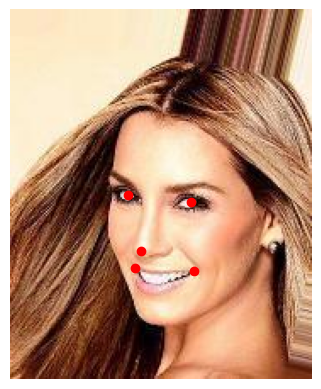

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Параметры из CSV


# Координаты ключевых точек
lefteye_x, lefteye_y = 69, 109
righteye_x, righteye_y = 106, 113
nose_x, nose_y = 77, 142
leftmouth_x, leftmouth_y = 73, 152
rightmouth_x, rightmouth_y = 108, 154

# Загрузка изображения
image = Image.open(image_path)

# Отображение изображения
fig, ax = plt.subplots()
ax.imshow(image)

# Список точек
points = [
    (lefteye_x, lefteye_y),
    (righteye_x, righteye_y),
    (nose_x, nose_y),
    (leftmouth_x, leftmouth_y),
    (rightmouth_x, rightmouth_y)
]

# Отрисовка точек
for (x, y) in points:
    ax.plot(x, y, 'ro')  # 'ro' — красный кружок

# Подписи точек (необязательно)

# Скрыть оси
plt.axis('off')
plt.show()
